In [ ]:
%pip install geodatasets

In [ ]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import ast
import re
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
import geopandas.tools as gpd_tools
from sklearn.metrics.pairwise import haversine_distances
from math import radians, sqrt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerPatch
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error as mse

In [ ]:
# Path to the zip file
zip_path = 'airbnb_data.zip'

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as z:
    # Filter out non-CSV or macOS metadata files
    csv_files = [file for file in z.namelist() if file.endswith('.csv') and '__MACOSX' not in file]

    # List to store the DataFrames
    dataframes = []
    for csv_file in csv_files:
        with z.open(csv_file) as f:
            df = pd.read_csv(f, encoding='utf-8', dtype={'license': 'object'})
            dataframes.append(df)

In [ ]:
df_original = pd.concat(dataframes, ignore_index=True)

In [4]:
df_original.shape

(805540, 75)

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805540 entries, 0 to 37540
Data columns (total 75 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            805540 non-null  int64  
 1   listing_url                                   805540 non-null  object 
 2   scrape_id                                     805540 non-null  int64  
 3   last_scraped                                  805540 non-null  object 
 4   source                                        805540 non-null  object 
 5   name                                          805481 non-null  object 
 6   description                                   710539 non-null  object 
 7   neighborhood_overview                         462615 non-null  object 
 8   picture_url                                   805535 non-null  object 
 9   host_id                                       805

In [6]:
df_original.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [102]:
drop_col = ['listing_url', 'scrape_id', 'source', 'name', 'description', 'neighborhood_overview',
            'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
            'host_response_time', 'host_response_rate', 'host_thumbnail_url', 'host_picture_url', 
            'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 
            'host_identity_verified', 'neighbourhood', 'bathrooms', 'minimum_minimum_nights', 'maximum_minimum_nights',
            'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
            'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90',
            'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm',
            'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
            'review_scores_value','license', 'calculated_host_listings_count', 
            'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms', 'reviews_per_month']

In [103]:
df = df_original.drop(columns=drop_col)

In [9]:
df_copy = df.copy()

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805540 entries, 0 to 37540
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            805540 non-null  int64  
 1   last_scraped                  805540 non-null  object 
 2   host_acceptance_rate          551879 non-null  object 
 3   host_is_superhost             760721 non-null  object 
 4   neighbourhood_cleansed        805540 non-null  object 
 5   neighbourhood_group_cleansed  805540 non-null  object 
 6   latitude                      805540 non-null  float64
 7   longitude                     805540 non-null  float64
 8   property_type                 805540 non-null  object 
 9   room_type                     805540 non-null  object 
 10  accommodates                  805540 non-null  int64  
 11  bathrooms_text                804605 non-null  object 
 12  bedrooms                      543049 non-null

In [105]:
df = df.sort_values(by=['id', 'last_scraped'], ignore_index=True)

In [12]:
df.head()

,id,last_scraped,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,instant_bookable
0,2595,2023-02-05,21%,f,Midtown,Manhattan,40.75356,-73.98559,Entire home/apt,1,1 bath,NaN,1.0,"[""Keypad"", ""Extra pillows and blankets"", ""TV"",...",$150.00,30,1125,f
1,2595,2023-03-07,22%,f,Midtown,Manhattan,40.75356,-73.98559,Entire home/apt,1,1 bath,NaN,1.0,"[""Hangers"", ""Bathtub"", ""Cleaning available dur...",$150.00,30,1125,f
2,2595,2023-04-05,22%,f,Midtown,Manhattan,40.75356,-73.98559,Entire home/apt,1,1 bath,NaN,1.0,"[""Bed linens"", ""Heating"", ""Wifi"", ""Stove"", ""Ba...",$240.00,30,1125,f
3,2595,2023-05-04,22%,f,Midtown,Manhattan,40.75356,-73.98559,Entire home/apt,1,1 bath,NaN,1.0,"[""Bed linens"", ""Heating"", ""Luggage dropoff all...",$240.00,30,1125,f
4,2595,2023-06-05,22%,f,Midtown,Manhattan,40.75356,-73.98559,Entire home/apt,1,1 bath,NaN,1.0,"[""Dedicated workspace"", ""Baking sheet"", ""Extra...",$240.00,30,1125,f


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805540 entries, 0 to 805539
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            805540 non-null  int64  
 1   last_scraped                  805540 non-null  object 
 2   host_acceptance_rate          551879 non-null  object 
 3   host_is_superhost             760721 non-null  object 
 4   neighbourhood_cleansed        805540 non-null  object 
 5   neighbourhood_group_cleansed  805540 non-null  object 
 6   latitude                      805540 non-null  float64
 7   longitude                     805540 non-null  float64
 8   room_type                     805540 non-null  object 
 9   accommodates                  805540 non-null  int64  
 10  bathrooms_text                804605 non-null  object 
 11  bedrooms                      543049 non-null  float64
 12  beds                          677985 non-nul

In [106]:
df['date'] = pd.to_datetime(df['last_scraped'])

df = df.drop(columns=['last_scraped'])

df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

In [107]:
df = df.dropna(subset=['price'])
df = df[df['price'] !=0]

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677511 entries, 0 to 805539
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   id                            677511 non-null  int64         
 1   host_acceptance_rate          518828 non-null  object        
 2   host_is_superhost             633175 non-null  object        
 3   neighbourhood_cleansed        677511 non-null  object        
 4   neighbourhood_group_cleansed  677511 non-null  object        
 5   latitude                      677511 non-null  float64       
 6   longitude                     677511 non-null  float64       
 7   property_type                 677511 non-null  object        
 8   room_type                     677511 non-null  object        
 9   accommodates                  677511 non-null  int64         
 10  bathrooms_text                676855 non-null  object        
 11  bedrooms     

In [109]:
df['id'].nunique()

66855

In [110]:
df.duplicated(subset=['id']).sum()

610656

In [111]:
df_price_avg = round(df.groupby('id')['price'].mean(), 2)
df_price_avg = df_price_avg.reset_index(level='id')

In [112]:
df = df.merge(df_price_avg, on=['id'], how='right')

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677511 entries, 0 to 677510
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   id                            677511 non-null  int64         
 1   host_acceptance_rate          518828 non-null  object        
 2   host_is_superhost             633175 non-null  object        
 3   neighbourhood_cleansed        677511 non-null  object        
 4   neighbourhood_group_cleansed  677511 non-null  object        
 5   latitude                      677511 non-null  float64       
 6   longitude                     677511 non-null  float64       
 7   property_type                 677511 non-null  object        
 8   room_type                     677511 non-null  object        
 9   accommodates                  677511 non-null  int64         
 10  bathrooms_text                676855 non-null  object        
 11  bedrooms     

In [114]:
df = df.drop_duplicates(subset=['id'], keep='last', ignore_index=True)

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66855 entries, 0 to 66854
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            66855 non-null  int64         
 1   host_acceptance_rate          49673 non-null  object        
 2   host_is_superhost             64951 non-null  object        
 3   neighbourhood_cleansed        66855 non-null  object        
 4   neighbourhood_group_cleansed  66855 non-null  object        
 5   latitude                      66855 non-null  float64       
 6   longitude                     66855 non-null  float64       
 7   property_type                 66855 non-null  object        
 8   room_type                     66855 non-null  object        
 9   accommodates                  66855 non-null  int64         
 10  bathrooms_text                66788 non-null  object        
 11  bedrooms                    

In [116]:
df = df.drop(columns=['id', 'date'])

In [117]:
df = df.rename(columns={'price_x':'price', 'neighbourhood_cleansed':'neighborhood',
                         'neighbourhood_group_cleansed':'borough', 'price_y':'price_avg'})

In [118]:
df.isnull().sum()

host_acceptance_rate    17182
host_is_superhost        1904
neighborhood                0
borough                     0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms_text             67
bedrooms                21608
beds                      995
amenities                   0
price                       0
minimum_nights              0
maximum_nights              0
instant_bookable            0
price_avg                   0
dtype: int64

In [119]:
missing_numeric_cols = []

for col in df.columns:
    if df[col].isnull().sum() > 0 and df[col].dtype != 'object':
        missing_numeric_cols.append(col)

for col in missing_numeric_cols:
     df.loc[:, col] = df[col].fillna(df[col].median())

In [120]:
missing_categorical_cols = []
for col in df.columns:
    if (df[col].isnull().sum() > 0 and df[col].dtype == 'object'):
         missing_categorical_cols.append(col)

for col in missing_categorical_cols:
     df.loc[:, col] = df[col].fillna(df[col].mode()[0])

In [121]:
df.isnull().sum()

host_acceptance_rate    0
host_is_superhost       0
neighborhood            0
borough                 0
latitude                0
longitude               0
property_type           0
room_type               0
accommodates            0
bathrooms_text          0
bedrooms                0
beds                    0
amenities               0
price                   0
minimum_nights          0
maximum_nights          0
instant_bookable        0
price_avg               0
dtype: int64

In [122]:
len(df[df['amenities'] == '[]'])

4812

In [123]:
df = df[df['amenities'] != '[]']

In [43]:
df.loc[0:10, 'amenities']

0    ["Keypad", "TV", "Stove", "Smoke alarm", "Cook...
1    ["Heating", "Air conditioning", "Wifi", "Kitch...
2    ["Dishwasher", "Cleaning products", "Stove", "...
3    ["Air conditioning", "Drying rack for clothing...
4    ["Air conditioning", "Free street parking", "F...
5    ["Air conditioning", "Kitchen", "Refrigerator"...
6    ["Self check-in", "Dishwasher", "Body soap", "...
7    ["Dishwasher", "TV", "Stove", "Smoke alarm", "...
8    ["Kitchen", "Hot water", "Free street parking"...
9    ["TV", "Stove", "Smoke alarm", "Washer", "Paid...
Name: amenities, dtype: object

In [44]:
df_amenities = df.copy()

def amenities_breakdown(amenities_list):
    return ast.literal_eval(amenities_list)

df_amenities['amenities'] = df['amenities'].apply(amenities_breakdown)

In [45]:
df_explode = df_amenities.explode('amenities')
print('Length of df_explode: ', len(df_explode))
print('Number of unique amenities: ', df_explode['amenities'].nunique())

Length of df_explode:  1678641
Number of unique amenities:  11158


In [46]:
top_10 = df_explode['amenities'].value_counts().head(10)
top_10

Wifi                     57515
Smoke alarm              56283
Kitchen                  53816
Carbon monoxide alarm    49052
Essentials               46802
Air conditioning         41900
Hot water                41761
Hangers                  41632
Heating                  39171
Hair dryer               37704
Name: amenities, dtype: int64

In [124]:
ac_keywords = ['AC', 'air conditioning'] 
df['has_air_conditioning'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in ac_keywords) else 0)

df['has_heating'] = df['amenities'].apply(lambda x: 1 if re.search(r'\bHeating\b', x, re.IGNORECASE) else 0)

wifi_keywords = ['wifi', 'ethernet']
df['has_wifi'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in wifi_keywords) else 0)

essentials_keywords = ['essentials', 'toilet paper', 'hand soap', 'body soap', 'towel', 'pillow', 'per guest', 'linens']
df['has_essentials'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in essentials_keywords) else 0)

df['has_kitchen'] = df['amenities'].apply(lambda x: 1 if re.search(r'\bkitchen\b', x, re.IGNORECASE) else 0)

tv_keywords = ['TV', 'cable']
df['has_television'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in tv_keywords) else 0)

df['has_washer'] = df['amenities'].apply(lambda x: 1 if re.search(r'\bWasher\b', x, re.IGNORECASE) else 0)

safety_keywords = ['security alarm', 'smoke alarm', 'carbon monoxide alarm', 'fire extinguisher', 'first-aid kit']
df['has_safety'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in safety_keywords) else 0)

workspace_keywords = ['office', 'workspace', 'work', 'remote']
df['has_workspace'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in workspace_keywords) else 0)

children_keywords = ['high chair', 'crib', 'baby safety gates']
df['children_friendly'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in children_keywords) else 0)

pet_keywords = ['furniture covers', 'bowls for pet food and water', 'pet', 'pets', 'dog', 'cat']
df['pet_friendly'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in pet_keywords) else 0)

gym_keywords = ['gym', 'fitness equipment', 'exercise', 'weight', 'training']
df['has_gym'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in gym_keywords) else 0)

df['has_pool'] = df['amenities'].apply(lambda x: 1 if re.search(r'\bpool\b', x, re.IGNORECASE) else 0)

fireplace_keywords = ['fireplace', 'pit']
df['has_fireplace'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in fireplace_keywords) else 0)

views_keywords = ['city views', 'city skyline view', 'skyline', 'views', 'cityscape']
df['has_views'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in views_keywords) else 0)

parking_keywords = ['parking', 'garage', 'car']
df['has_parking'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in parking_keywords) else 0)

In [125]:
df = df.drop(columns='amenities')

In [48]:
amenities = df.iloc[:, -16:]

amenity_labels = [amenity for amenity in amenities.columns]

amenities_value_counts = []

for i, amenity in enumerate(amenities):
    value_counts = df[amenity].value_counts()
    value_counts.name = value_counts.name.replace('has_', ' ').replace('_', ' ').title()
    amenities_value_counts.append(value_counts)
    

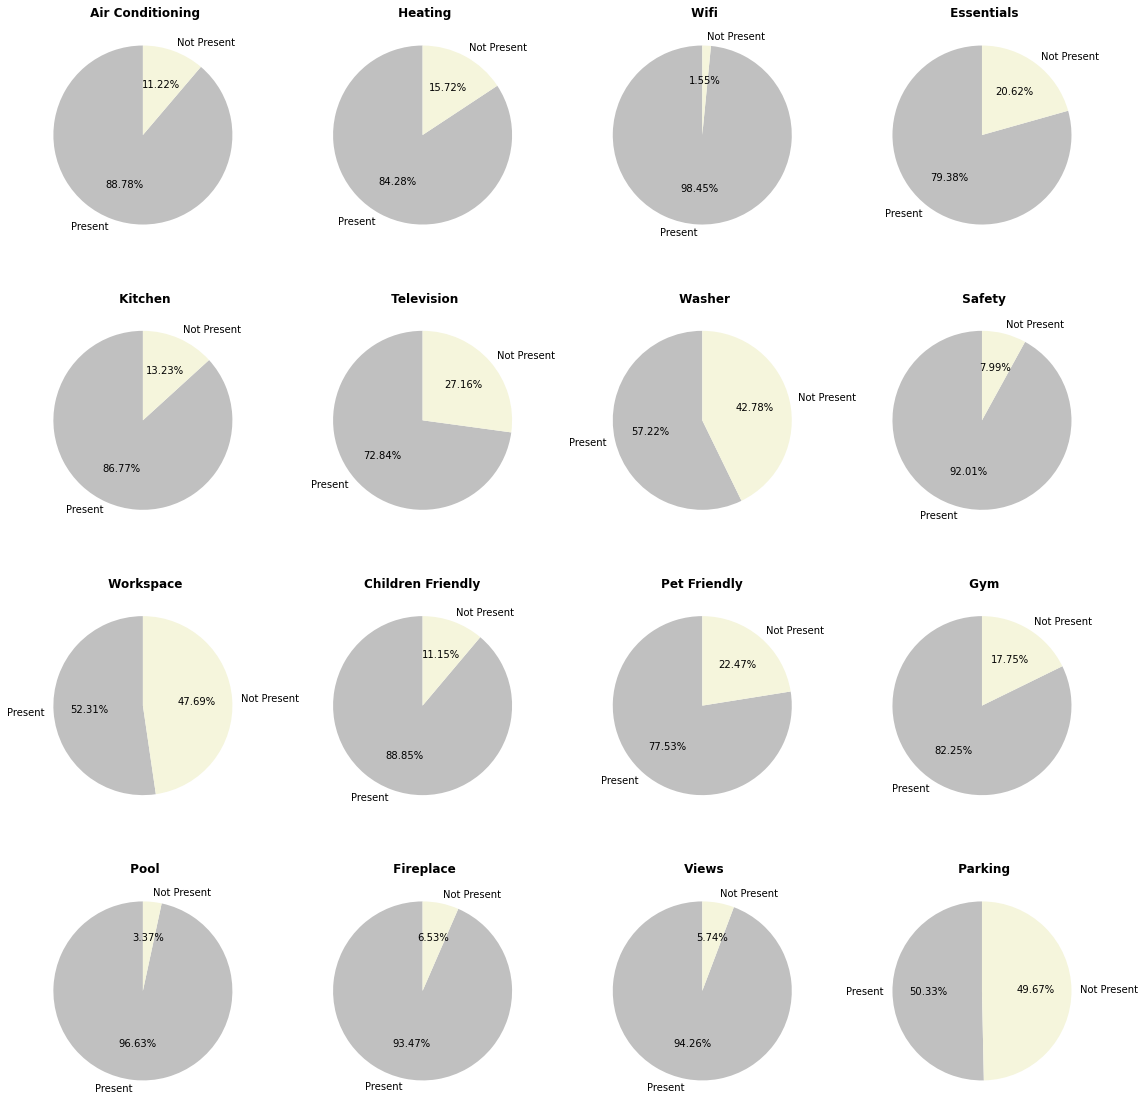

In [49]:
fig, axes = plt.subplots(4, 4, figsize=(16,16))
axes = axes.ravel()

for i, amenity in enumerate(amenities_value_counts):
    ax=axes[i]
    ax.pie(amenity, autopct='%1.2f%%', startangle=90,
           colors=['silver', 'beige'], labels=['Present', 'Not Present'])
    ax.set_title(amenity.name, fontdict={'fontweight':'bold'})
    
plt.tight_layout()
plt.show()

In [50]:
num_neighborhoods = df['neighborhood'].nunique()
num_boroughs = df['borough'].nunique()
print(f"# of neighborhoods: {num_neighborhoods}\n# of boroughs: {num_boroughs}")

# of neighborhoods: 225
# of boroughs: 5


In [51]:
df.groupby(['borough','neighborhood'])['neighborhood'].size()

borough        neighborhood 
Bronx          Allerton         78
               Baychester       51
               Belmont          53
               Bronxdale        27
               Castle Hill      14
                                ..
Staten Island  Tottenville       6
               West Brighton    41
               Westerleigh       6
               Willowbrook       2
               Woodrow           4
Name: neighborhood, Length: 225, dtype: int64

In [52]:
borough_count = df['borough'].value_counts()
print('Number of Listings in Each Borough:')
print(borough_count)

df_borough_pivot = round(df.pivot_table(values='price_avg', index='borough', 
                                  aggfunc=['mean', 'median']).sort_values(by=('median', 'price_avg'), ascending=False),2)
print('\nMean and Median Prices in Each Borough:')
print(df_borough_pivot)

Number of Listings in Each Borough:
Manhattan        27637
Brooklyn         21911
Queens            9590
Bronx             2307
Staten Island      598
Name: borough, dtype: int64

Mean and Median Prices in Each Borough:
                   mean    median
              price_avg price_avg
borough                          
Manhattan        295.57    189.20
Brooklyn         170.36    119.00
Staten Island    242.91    101.48
Queens           136.25     96.20
Bronx            121.70     90.67


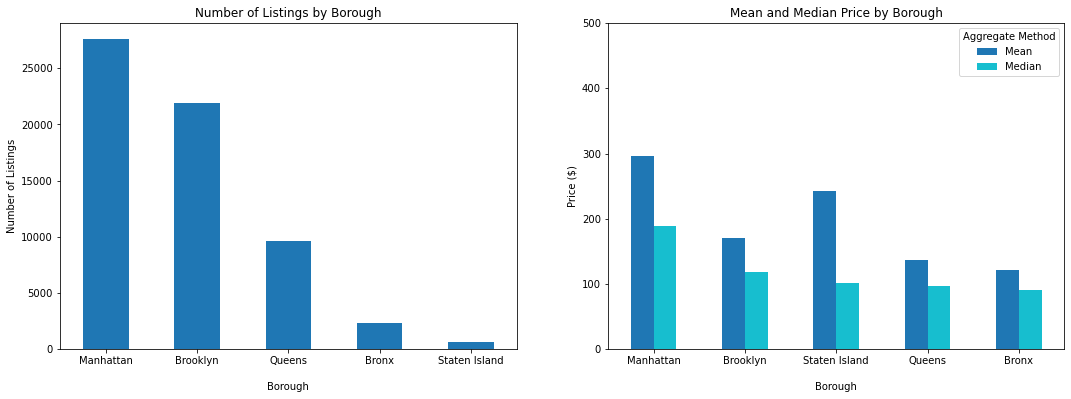

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

borough_count.plot.bar(ax=ax[0])
ax[0].set_xticklabels(labels=ax[0].get_xticklabels(), rotation=360)
ax[0].set_xlabel('\nBorough')
ax[0].set_ylabel('Number of Listings')
ax[0].set_title('Number of Listings by Borough')

df_borough_pivot.plot.bar(ax=ax[1], cmap='tab10')
ax[1].set_xticklabels(labels=ax[1].get_xticklabels(), rotation=360)
ax[1].set_xlabel('\nBorough')
ax[1].set_ylabel('Price ($)')
ax[1].set_title('Mean and Median Price by Borough')
ax[1].set_ylim(0,500)
ax[1].legend(title='Aggregate Method', labels=['Mean', 'Median'])

plt.show()

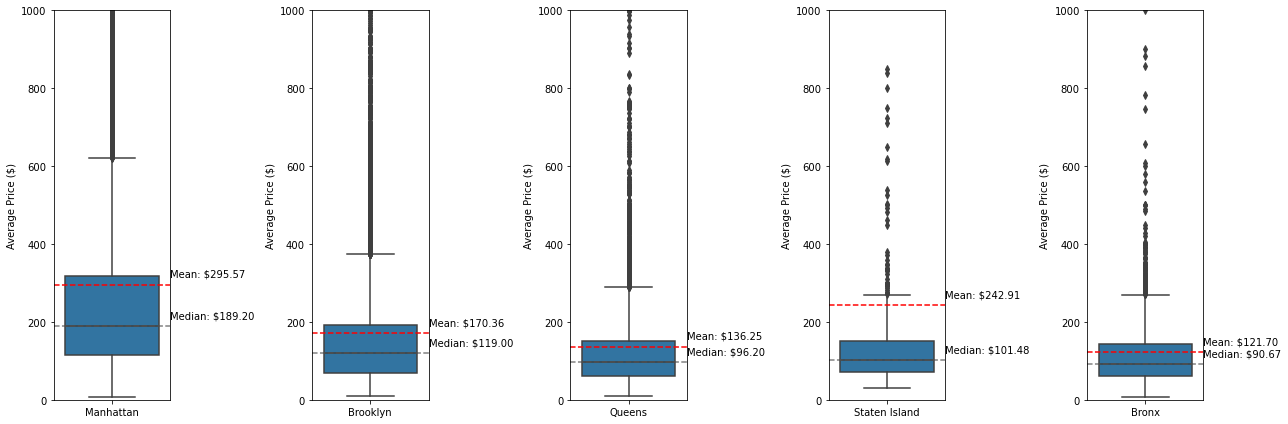

In [54]:
boroughs = df['borough'].unique()

fig, axes = plt.subplots(1, 5, figsize=(18, 6))
axes = axes.ravel()

for i, borough in enumerate(boroughs):
    ax=axes[i]
    median = df[df['borough']==borough]['price_avg'].median()
    mean = df[df['borough']==borough]['price_avg'].mean()
    sns.boxplot(data=df[df['borough'] == borough], x='borough', y=df['price_avg'], ax=ax)
    ax.set_ylim(0,1000)
    ax.axhline(mean, linestyle='--', color='red')
    ax.text(0.5, mean + 20, f'Mean: ${mean:.2f}', color='black')
    ax.axhline(median, linestyle='--', color='grey')
    ax.text(0.5, median + 20, f'Median: ${median:.2f}', color='black')
    ax.set_xlabel('')
    ax.set_ylabel('Average Price ($)')
plt.tight_layout()
plt.show()

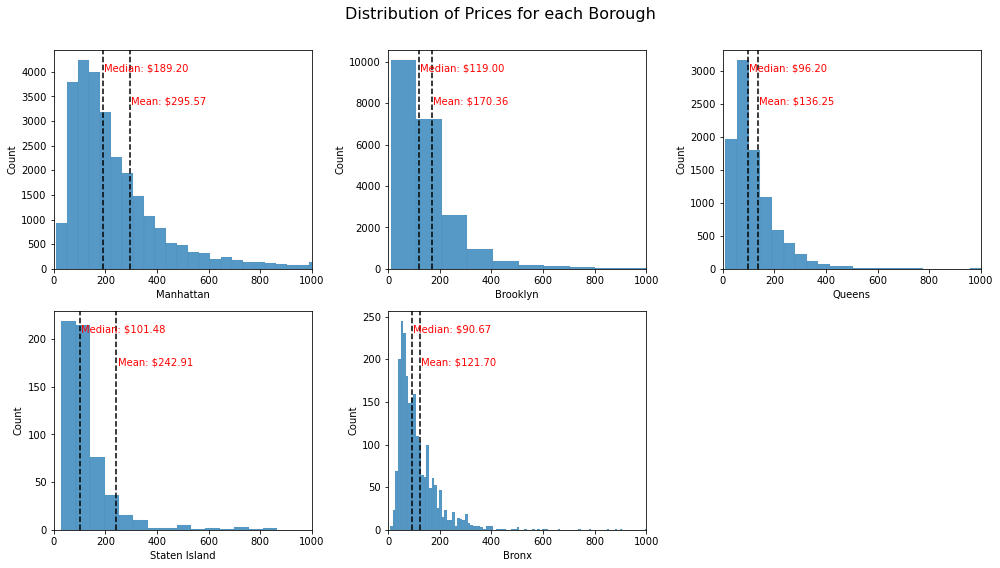

In [55]:
boroughs = df['borough'].unique()

fig, axes = plt.subplots(2, 3, figsize=(14,8))
axes[1, 2].axis('off')
axes = axes.ravel()

for i, borough in enumerate(boroughs):
    ax=axes[i]
    median = df[df['borough']==borough]['price_avg'].median()
    mean = df[df['borough']==borough]['price_avg'].mean()
    sns.histplot(data=df[df['borough']==borough], x='price_avg', bins=1000, ax=ax, line_kws={'median':median})
    ax.set_xlim(0,1000)
    ax.set_xlabel(borough)
    ymax = ax.get_ylim()[1]
    ax.axvline(x=median, linestyle='--', color='black')
    ax.text(median + 5, ymax * 0.9, f'Median: ${median:.2f}', color='red')
    ax.axvline(x=mean, linestyle='--', color='black')
    ax.text(mean + 5, ymax * 0.75, f'Mean: ${mean:.2f}', color='red')


plt.suptitle('Distribution of Prices for each Borough\n', fontsize=16)
plt.tight_layout()
plt.show()

In [56]:
df_room_type_counts = df['room_type'].value_counts()
print('Number of Listings for each Room Type')
print(df_room_type_counts)

df_room_type_pivot = round(df.pivot_table(values='price_avg', index='room_type', 
                                    aggfunc=['mean', 'median']).sort_values(by=('mean', 'price_avg'), ascending=False),2)
print('\nMean and Median Prices for each Room Type')
print(df_room_type_pivot)

Number of Listings for each Room Type
Entire home/apt    34122
Private room       26572
Shared room          820
Hotel room           529
Name: room_type, dtype: int64

Mean and Median Prices for each Room Type
                     mean    median
                price_avg price_avg
room_type                          
Hotel room         456.38    338.00
Entire home/apt    276.93    193.43
Private room       145.22     80.00
Shared room        103.36     60.00


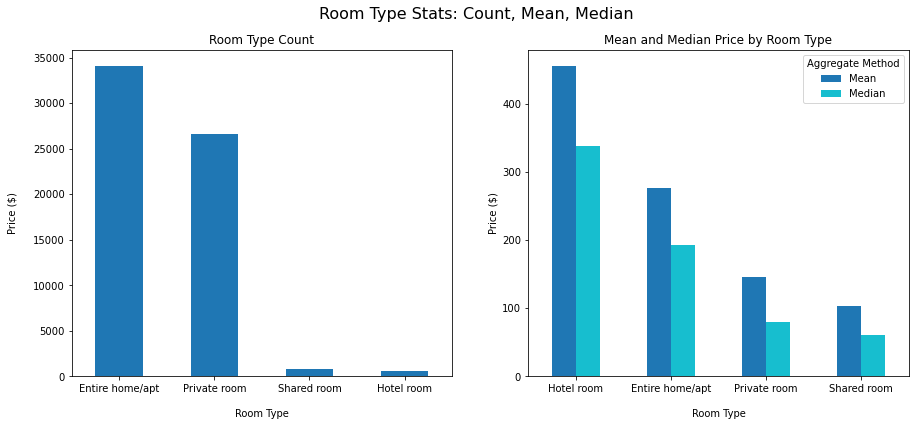

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

df_room_type_counts.plot.bar(ax=ax[0])
ax[0].set_xticklabels(labels=ax[0].get_xticklabels(), rotation=360)
ax[0].set_xlabel('\nRoom Type')
ax[0].set_ylabel('Price ($)\n')
ax[0].set_title('Room Type Count')

df_room_type_pivot.plot.bar(ax=ax[1], cmap='tab10')
ax[1].set_xticklabels(labels=ax[1].get_xticklabels(), rotation=360)
ax[1].set_xlabel('\nRoom Type')
ax[1].set_ylabel('Price ($)')
ax[1].set_title('Mean and Median Price by Room Type')
ax[1].legend(title='Aggregate Method', labels=['Mean', 'Median'])
plt.suptitle('Room Type Stats: Count, Mean, Median', fontsize=16)
plt.show()

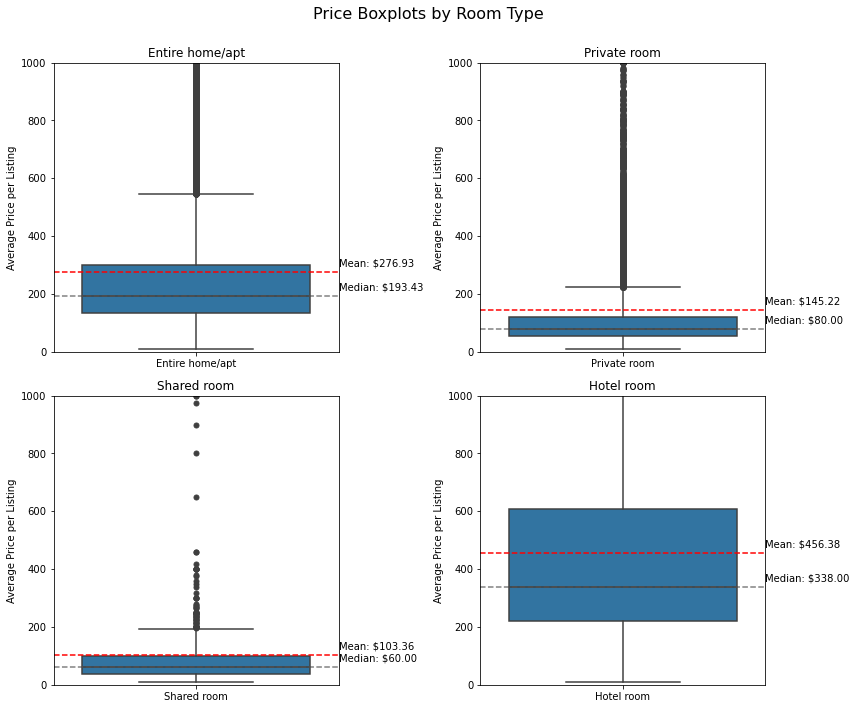

In [58]:
room_types = df['room_type'].unique()
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, room_type in enumerate(room_types):
    median = df[df['room_type']==room_type]['price_avg'].median()
    mean = df[df['room_type']==room_type]['price_avg'].mean()
    ax = axes[i]
    sns.boxplot(x='room_type', y='price_avg', data = df[df['room_type'] == room_type], ax=ax, flierprops=dict(marker='o'))
    ax.set_title(room_type)
    ax.axhline(mean, linestyle='--', color='red')
    ax.text(0.5, mean + 20, f'Mean: ${mean:.2f}', color='black')
    ax.axhline(median, linestyle='--', color='grey')
    ax.text(0.5, median + 20, f'Median: ${median:.2f}', color='black')
    ax.set_xlabel('')
    ax.set_ylabel('Average Price per Listing')
    ax.set_ylim(0,1000)

plt.suptitle('Price Boxplots by Room Type\n', fontsize=16)
plt.tight_layout() 
plt.show()

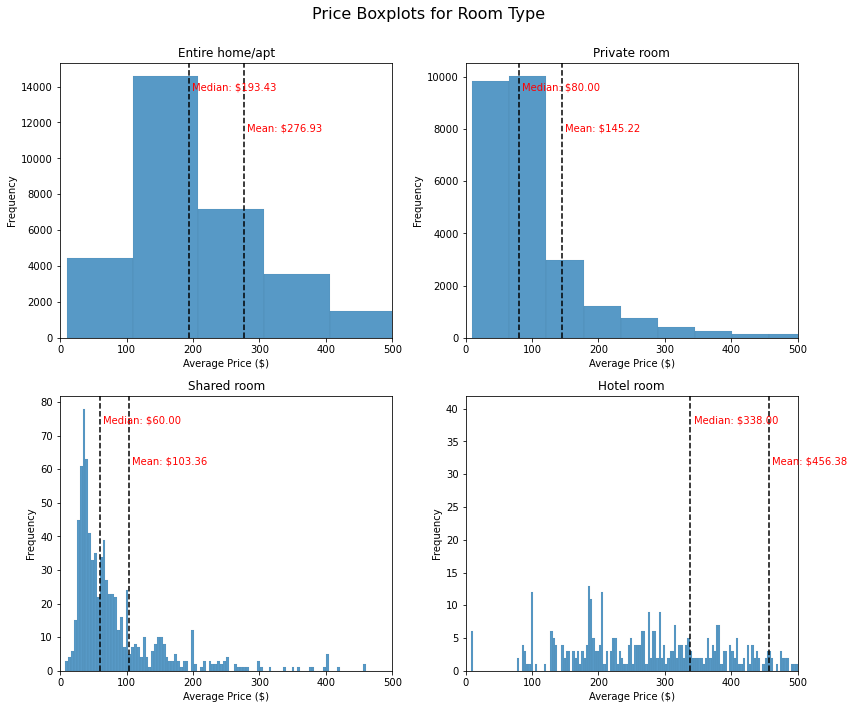

In [59]:
room_types = df['room_type'].unique()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # Flatten the axes array

for i, room_type in enumerate(room_types):
    median = df[df['room_type']==room_type]['price_avg'].median()
    mean = df[df['room_type']==room_type]['price_avg'].mean()
    ax = axes[i]
    sns.histplot(data=df[df['room_type'] == room_type], x='price_avg', bins=1000, ax=ax, edgecolor='black')
    ax.set_xlim(0, 500)
    ax.set_title(room_type)
    ax.set_xlabel('Average Price ($)')
    ax.set_ylabel('Frequency')
    ymax = ax.get_ylim()[1]
    ax.axvline(x=median, linestyle='--', color='black')
    ax.text(median + 5, ymax * 0.9, f'Median: ${median:.2f}', color='red')
    ax.axvline(x=mean, linestyle='--', color='black')
    ax.text(mean + 5, ymax * 0.75, f'Mean: ${mean:.2f}', color='red')

plt.suptitle('Price Boxplots for Room Type\n', fontsize=16)
plt.tight_layout()
plt.show()


In [60]:
room_types

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [126]:
df = df[df['room_type'] != 'Hotel room']

In [62]:
df['bathrooms_text'].unique()

array(['1 bath', '1.5 baths', '1 shared bath', '1 private bath',
       'Shared half-bath', '2 baths', '3 baths', 'Half-bath',
       '2 shared baths', '2.5 baths', '1.5 shared baths', '5 baths',
       '0 shared baths', '5.5 baths', '4.5 baths', '3.5 baths',
       '2.5 shared baths', 'Private half-bath', '0 baths',
       '3.5 shared baths', '15.5 baths', '4 baths', '3 shared baths',
       '10.5 baths', '4 shared baths', '4.5 shared baths', '6 baths',
       '6.5 baths', '7 baths', '11.5 baths', '6 shared baths',
       '7.5 baths', '5.5 shared baths', '8 baths', '5 shared baths'],
      dtype=object)

In [127]:
df = df.assign(shared_bathroom=df['bathrooms_text'].apply(lambda x: 1 if re.search(r'\bShared\b', x, re.IGNORECASE) else 0))

In [128]:
def extract_number(text):
    text = text.lower().replace('half-bath', '0.5')
    number = re.search(r'\d+(\.\d+)?', text)  # Match integers and floating-point numbers
    return float(number.group()) if number else None  # Convert to float

df = df.assign(bathrooms=df['bathrooms_text'].apply(extract_number))

In [129]:
df.loc[(df['bathrooms_text'] == 'Half-bath') | 
       (df['bathrooms_text'] == 'Shared half-bath') | 
       (df['bathrooms_text'] == 'Private half-bath')][['bathrooms_text', 'shared_bathroom', 'bathrooms']]

,bathrooms_text,shared_bathroom,bathrooms
28,Shared half-bath,1,0.5
56,Half-bath,0,0.5
464,Shared half-bath,1,0.5
481,Shared half-bath,1,0.5
867,Half-bath,0,0.5
...,...,...,...
66325,Half-bath,0,0.5
66517,Private half-bath,0,0.5
66711,Half-bath,0,0.5
66727,Half-bath,0,0.5


In [130]:
df['bathrooms'].isnull().sum()

0

In [131]:
df = df.drop(columns='bathrooms_text')

In [67]:
shared_bathrooms_count = df['shared_bathroom'].value_counts()
print('Shared Bathroom Count (0 = Private, 1 = Shared)')
print(shared_bathrooms_count)

bathrooms_count = df['bathrooms'].value_counts().sort_index()
print('\nNumber of Bathrooms Count')
print(bathrooms_count)

Shared Bathroom Count (0 = Private, 1 = Shared)
0    45478
1    16036
Name: shared_bathroom, dtype: int64

Number of Bathrooms Count
0.0      1164
0.5       144
1.0     48752
1.5      2738
2.0      6653
2.5       724
3.0       762
3.5       166
4.0       263
4.5        65
5.0        40
5.5        18
6.0         8
6.5         3
7.0         5
7.5         4
8.0         2
10.5        1
11.5        1
15.5        1
Name: bathrooms, dtype: int64


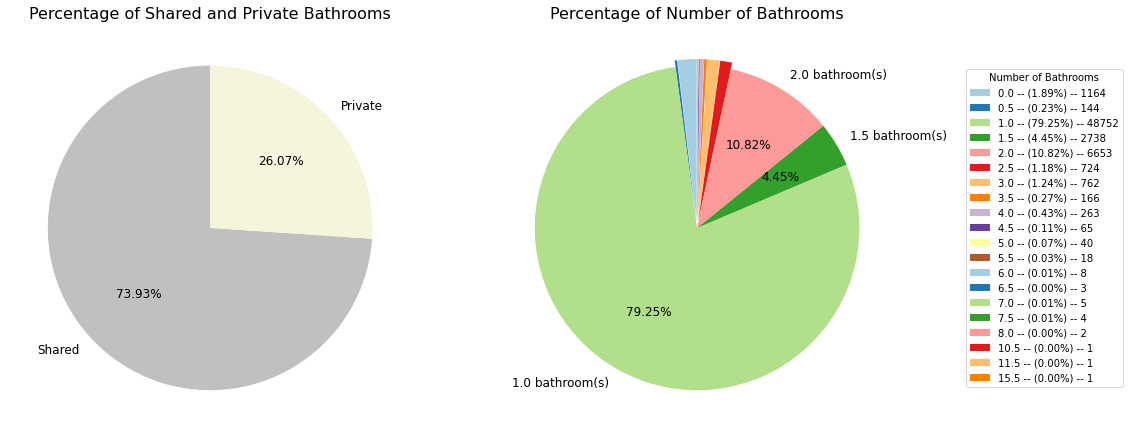

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# First Pie Chart for Shared and Private Bathrooms
axes[0].pie(
    shared_bathrooms_count, labels=['Shared', 'Private'], startangle=90,
    autopct='%1.2f%%', colors=['silver', 'beige'],textprops={'fontsize': 12}
)
axes[0].set_title('Percentage of Shared and Private Bathrooms', fontdict={'fontsize': 16})

# ---------------------------------------------------------------------------
# Second Pie Chart for Number of Bathrooms

# Calculations for pie chart labels and explode
percentages = bathrooms_count / bathrooms_count.sum()
labels = bathrooms_count.index
show_labels = percentages > 0.04

# Explode slices with percentages less than 4%
small_slices = bathrooms_count[percentages < 0.04]
explode = [0.04 if index in small_slices.index else 0 for index in bathrooms_count.index]

wedges, texts, autotexts = axes[1].pie(
    bathrooms_count,
    labels=[f'{label} bathroom(s)' if show else '' for label, show in zip(labels, show_labels)],
    autopct=lambda p: f'{p:.2f}%' if p > 4 else '',
    explode=explode,
    startangle=90,
    colors=plt.cm.Paired.colors,
    textprops={'fontsize': 12}
)

# Add legend with corresponding percentages and counts
legend_labels = [
    f'{label} -- ({bathrooms_count[label] / bathrooms_count.sum():.2%}) -- {bathrooms_count[label]}'
    for label in bathrooms_count.index
]
axes[1].legend(wedges, legend_labels, title='Number of Bathrooms', loc='center left', bbox_to_anchor=(1.15, 0, 1, 1))

axes[1].set_title('Percentage of Number of Bathrooms', fontdict={'fontsize': 16})

plt.show()

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61514 entries, 0 to 66854
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   host_acceptance_rate  61514 non-null  object        
 1   host_is_superhost     61514 non-null  object        
 2   neighborhood          61514 non-null  object        
 3   borough               61514 non-null  object        
 4   latitude              61514 non-null  float64       
 5   longitude             61514 non-null  float64       
 6   room_type             61514 non-null  object        
 7   accommodates          61514 non-null  int64         
 8   bathrooms_text        61514 non-null  object        
 9   bedrooms              61514 non-null  float64       
 10  beds                  61514 non-null  float64       
 11  amenities             61514 non-null  object        
 12  price                 61514 non-null  float64       
 13  minimum_nights  

In [132]:
numeric_cols = df.select_dtypes(include=[np.number])

In [90]:
len(numeric_cols.columns)

27

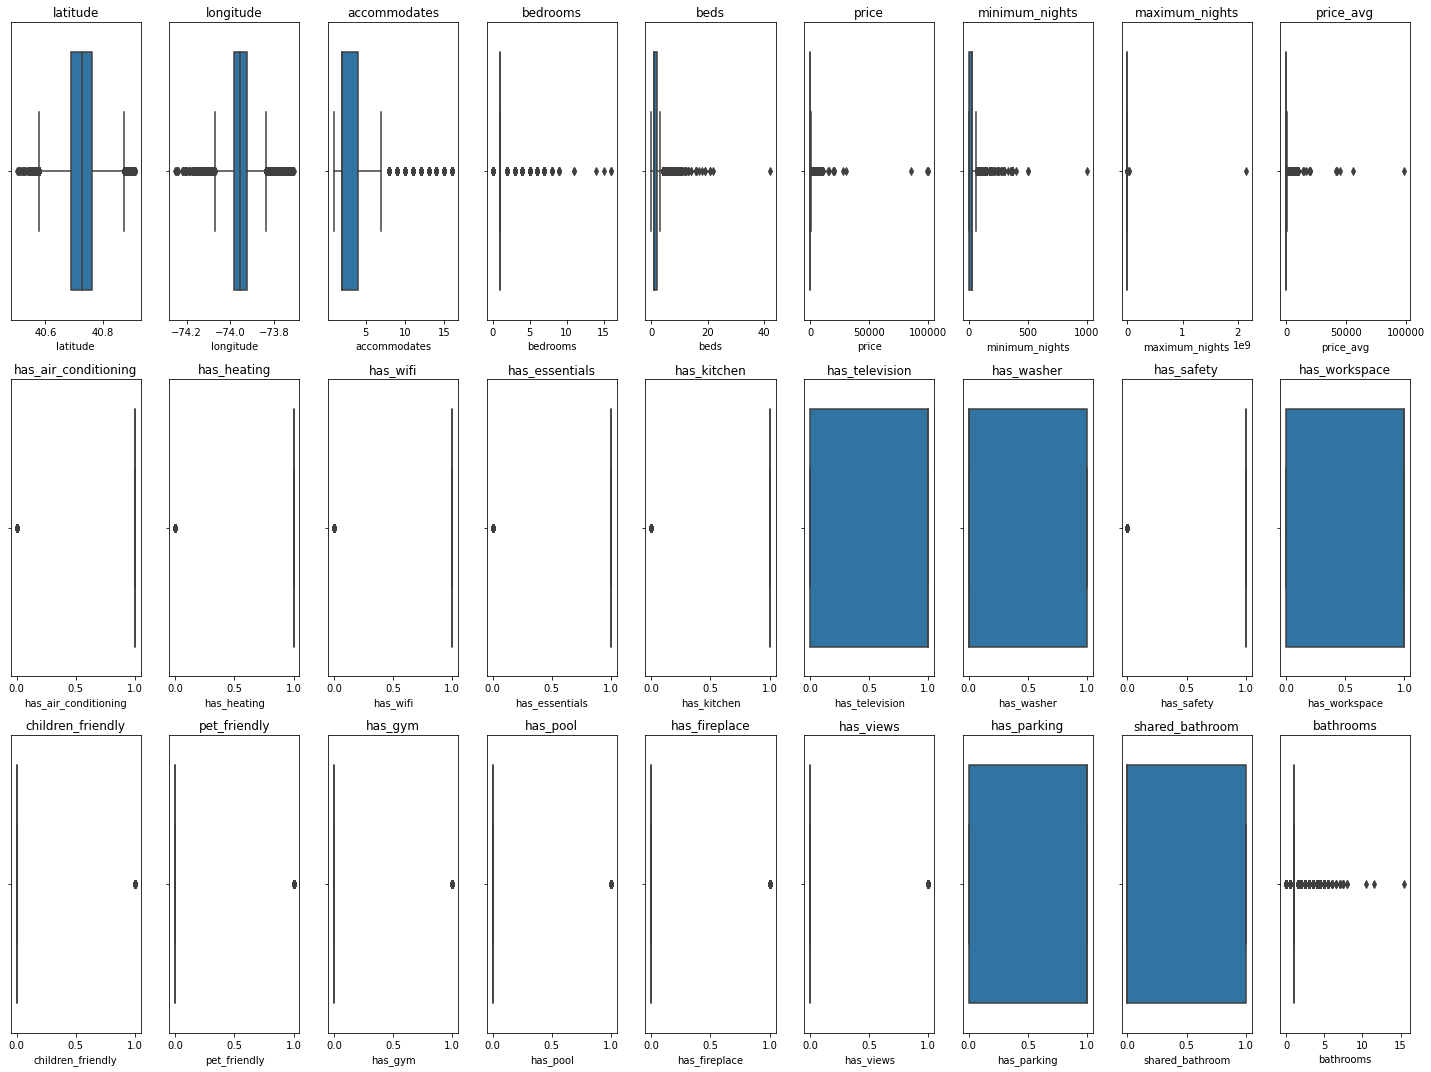

In [133]:
fig, axes = plt.subplots(3, 9, figsize=(20, 15))

axes = axes.ravel()

for i, col in enumerate(numeric_cols.columns):
    ax = axes[i]
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [ ]:
df[df['accommodates'] >= 7][['neighborhood', 'room_type', 'bedrooms', 'accommodates', 'beds', 'price', 'price_avg', 'shared_bathroom', 'bathrooms']]

In [134]:
def remove_outliers(df, columns):

    # Create a copy of the DataFrame to avoid modifying the original
    df_outliers = df.copy()

    for col in columns:
        original_dtype = df_outliers[col].dtype
        q1, q3 = df_outliers[col].quantile(0.25), df_outliers[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound, upper_bound = q1 - (1.5*iqr), q3 + (1.5*iqr)
        outliers = (df_outliers[col] < lower_bound) | (df_outliers[col] > upper_bound)
        df_outliers = df[~outliers]
    return df_outliers

df_remove_outliers = remove_outliers(df, ['price'])

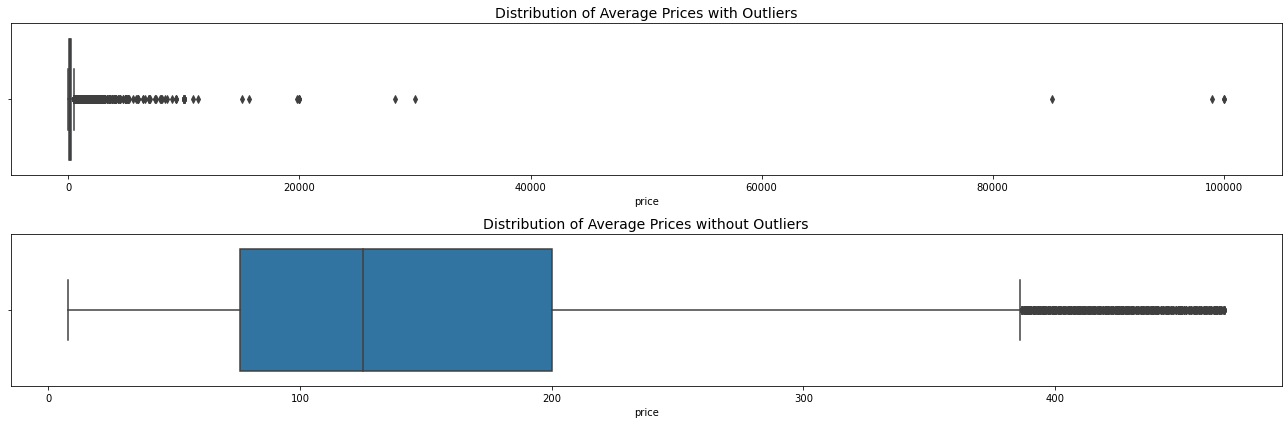

In [135]:
fig, ax = plt.subplots(2, 1, figsize=(18, 6))

sns.boxplot(x = df['price'], ax=ax[0])
ax[0].set_title('Distribution of Average Prices with Outliers', fontsize=14)

sns.boxplot(x = df_remove_outliers['price'], ax=ax[1])
ax[1].set_title('Distribution of Average Prices without Outliers', fontsize=14)

plt.tight_layout()
plt.show()

In [197]:
df_remove_outliers[['price', 'price_avg']].describe()

,price,price_avg
count,56866.000000,56866.000000
mean,152.565575,157.151930
std,98.066724,331.857439
min,8.000000,8.000000
25%,76.000000,77.000000
50%,125.000000,127.565000
75%,200.000000,200.000000
max,467.000000,55822.140000


In [ ]:
df.info()

In [422]:
# Create a GeoDataFrame for compatability
geometry = [Point(xy) for xy in zip(df_remove_outliers['longitude'], df_remove_outliers['latitude'])]
gdf_airbnb = gpd.GeoDataFrame(df_remove_outliers, geometry=geometry, crs="EPSG:4326")

# Load NYC boroughs shapefile from geodatasets
nybb_path = geodatasets.get_path('nybb')
nybb = gpd.read_file(nybb_path)

In [ ]:
# Plot boroughs outlines
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
nybb.to_crs("EPSG:4326").plot(ax=ax[0], color="white", edgecolor="black")
nybb.to_crs("EPSG:4326").plot(ax=ax[1], color="white", edgecolor="black")

# Create color palettes for price and room type plots
price_palette = sns.color_palette('viridis', as_cmap=True)
room_type_palette = sns.color_palette('flare', n_colors=len(gdf_airbnb['room_type'].unique()))

# Create scatter plot for Airbnb listings on the first subplot
scatter = ax[0].scatter(x=gdf_airbnb['longitude'], y=gdf_airbnb['latitude'], c=gdf_airbnb['price_avg'], cmap=price_palette, s=1, alpha=0.6)

# Add color bar for the first plot and format title/labels
cbar = plt.colorbar(scatter, ax=ax[0], label='Price')
cbar.set_label('Price', fontsize=12)
ax[0].set_title('Airbnb Locations in NYC with Price Color Map', fontsize=15)
ax[0].set_xlabel('Longitude', fontsize=12)
ax[0].set_ylabel('Latitude', fontsize=12)

# Configure room type scatterplot by unique room type
for room_type, color in zip(gdf_airbnb['room_type'].unique(), room_type_palette):
    subset = gdf_airbnb[gdf_airbnb['room_type'] == room_type]
    subset.plot(ax=ax[1], markersize=1, color=color, alpha=0.6, label=room_type)

# Add legend for the second plot and format title/labels
handles = [Patch(facecolor=color, edgecolor='black', label=room_type) 
           for room_type, color in zip(gdf_airbnb['room_type'].unique(), room_type_palette)]

ax[1].legend(handles=handles, title="Room Types", loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_title('Airbnb Locations in NYC by Room Type', fontsize=15)
ax[1].set_xlabel('Longitude', fontsize=12)
ax[1].set_ylabel('Latitude', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
boroughs = df_remove_outliers['borough'].unique()

fig, axes = plt.subplots(2, 3, figsize=(14,8))
axes[1, 2].axis('off')
axes = axes.ravel()

for i, borough in enumerate(boroughs):
    ax=axes[i]
    median = df_remove_outliers[df_remove_outliers['borough']==borough]['price_avg'].median()
    mean = df_remove_outliers[df_remove_outliers['borough']==borough]['price_avg'].mean()
    sns.histplot(data=df_remove_outliers[df_remove_outliers['borough']==borough], x='price_avg', bins=30, ax=ax, line_kws={'median':median})
    ax.set_xlim(0,500)
    ax.set_xlabel(borough)
    ymax = ax.get_ylim()[1]
    ax.axvline(x=median, linestyle='--', color='black')
    ax.text(median + 5, ymax * 0.9, f'Median: ${median:.2f}', color='red')
    ax.axvline(x=mean, linestyle='--', color='black')
    ax.text(mean + 5, ymax * 0.75, f'Mean: ${mean:.2f}', color='red')


plt.suptitle('Distribution of Prices for each Borough\n', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
room_types = df_remove_outliers['room_type'].unique()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # Flatten the axes array

for i, room_type in enumerate(room_types):
    median = df_remove_outliers[df_remove_outliers['room_type']==room_type]['price_avg'].median()
    mean = df_remove_outliers[df_remove_outliers['room_type']==room_type]['price_avg'].mean()
    ax = axes[i]
    sns.histplot(data=df_remove_outliers[df_remove_outliers['room_type'] == room_type], x='price_avg', bins=30, ax=ax, edgecolor='black')
    ax.set_xlim(0, 500)
    ax.set_title(room_type)
    ax.set_xlabel('Average Price ($)')
    ax.set_ylabel('Frequency')
    ymax = ax.get_ylim()[1]
    ax.axvline(x=median, linestyle='--', color='black')
    ax.text(median + 5, ymax * 0.9, f'Median: ${median:.2f}', color='red')
    ax.axvline(x=mean, linestyle='--', color='black')
    ax.text(mean + 5, ymax * 0.75, f'Mean: ${mean:.2f}', color='red')

plt.suptitle('Price Boxplots for Room Type\n', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
df_remove_outliers.info()

In [136]:
airbnb_df = df_remove_outliers[['latitude', 'longitude']].copy()
airbnb_df = airbnb_df.drop_duplicates(subset=['latitude', 'longitude']).reset_index()
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54464 entries, 0 to 54463
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      54464 non-null  int64  
 1   latitude   54464 non-null  float64
 2   longitude  54464 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.2 MB


In [137]:
# Load csv file of metro and bus station coordinates of NYC
transit_df = pd.read_csv('metro_data.csv')

# Convert latitude and longitude to radians
airbnb_df['lat_rad'] = airbnb_df['latitude'].apply(radians)
airbnb_df['lon_rad'] = airbnb_df['longitude'].apply(radians)
transit_df['lat_rad'] = transit_df['stop_lat'].apply(radians)
transit_df['lon_rad'] = transit_df['stop_lon'].apply(radians)

earth_radius_mi = 3963.1906

# Calculate haversine distances
distances = haversine_distances(transit_df[['lat_rad', 'lon_rad']].values,
                                airbnb_df[['lat_rad', 'lon_rad']].values) * earth_radius_mi

# Extract minimum distance, Store it as a DataFrame, and add to airbnb_df
nearest_transit = distances.min(axis=0)
airbnb_df['nearest_transit'] = pd.DataFrame(nearest_transit, columns=['nearest_transit'])

In [138]:
# Merge airbnb_df with the df using the common columns 'latitude' and 'longitude'
airbnb_df = airbnb_df.drop(columns=['index', 'lat_rad', 'lon_rad'])
df_remove_outliers = pd.merge(df_remove_outliers, airbnb_df, how='left', on=['latitude', 'longitude'])

In [139]:
df_remove_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56866 entries, 0 to 56865
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_acceptance_rate  56866 non-null  object 
 1   host_is_superhost     56866 non-null  object 
 2   neighborhood          56866 non-null  object 
 3   borough               56866 non-null  object 
 4   latitude              56866 non-null  float64
 5   longitude             56866 non-null  float64
 6   property_type         56866 non-null  object 
 7   room_type             56866 non-null  object 
 8   accommodates          56866 non-null  int64  
 9   bedrooms              56866 non-null  float64
 10  beds                  56866 non-null  float64
 11  price                 56866 non-null  float64
 12  minimum_nights        56866 non-null  int64  
 13  maximum_nights        56866 non-null  int64  
 14  instant_bookable      56866 non-null  object 
 15  price_avg          

In [142]:
df_categorical_features = df_remove_outliers.select_dtypes(include='object')

categorical_features = df_categorical_features.columns

df_numeric_features = df_remove_outliers.select_dtypes(include=[np.number])

numeric_features = df_numeric_features.columns


In [143]:
df_categorical_features = df_remove_outliers.select_dtypes(include='object')
categorical_features = df_categorical_features.columns

df_numeric_features = df_remove_outliers.select_dtypes(include=[np.number])
numeric_features = df_numeric_features.columns

categorical_pipeline = Pipeline([('ordinal_encoder', OrdinalEncoder())]
                                )
preprocessing_pipeline = ColumnTransformer([
    ("categorical", categorical_pipeline, categorical_features),
    ("numerical", "passthrough", numeric_features),  # Pass numerical features through without changes
])

# Prepare data by applying the preprocessing pipeline
df_prepared = preprocessing_pipeline.fit_transform(df_remove_outliers)

# Create a DataFrame from the transformed features
df_prepared = pd.DataFrame(df_prepared, columns=categorical_features.tolist() + numeric_features.tolist())

In [146]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56866 entries, 0 to 56865
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_acceptance_rate  56866 non-null  float64
 1   host_is_superhost     56866 non-null  float64
 2   neighborhood          56866 non-null  float64
 3   borough               56866 non-null  float64
 4   property_type         56866 non-null  float64
 5   room_type             56866 non-null  float64
 6   instant_bookable      56866 non-null  float64
 7   latitude              56866 non-null  float64
 8   longitude             56866 non-null  float64
 9   accommodates          56866 non-null  float64
 10  bedrooms              56866 non-null  float64
 11  beds                  56866 non-null  float64
 12  price                 56866 non-null  float64
 13  minimum_nights        56866 non-null  float64
 14  maximum_nights        56866 non-null  float64
 15  price_avg          

In [147]:
# Shift 'price' feature to the end of the DataFrame for correlation analysis
col = df_prepared.pop('price')
df_prepared.insert(34, col.name, col)

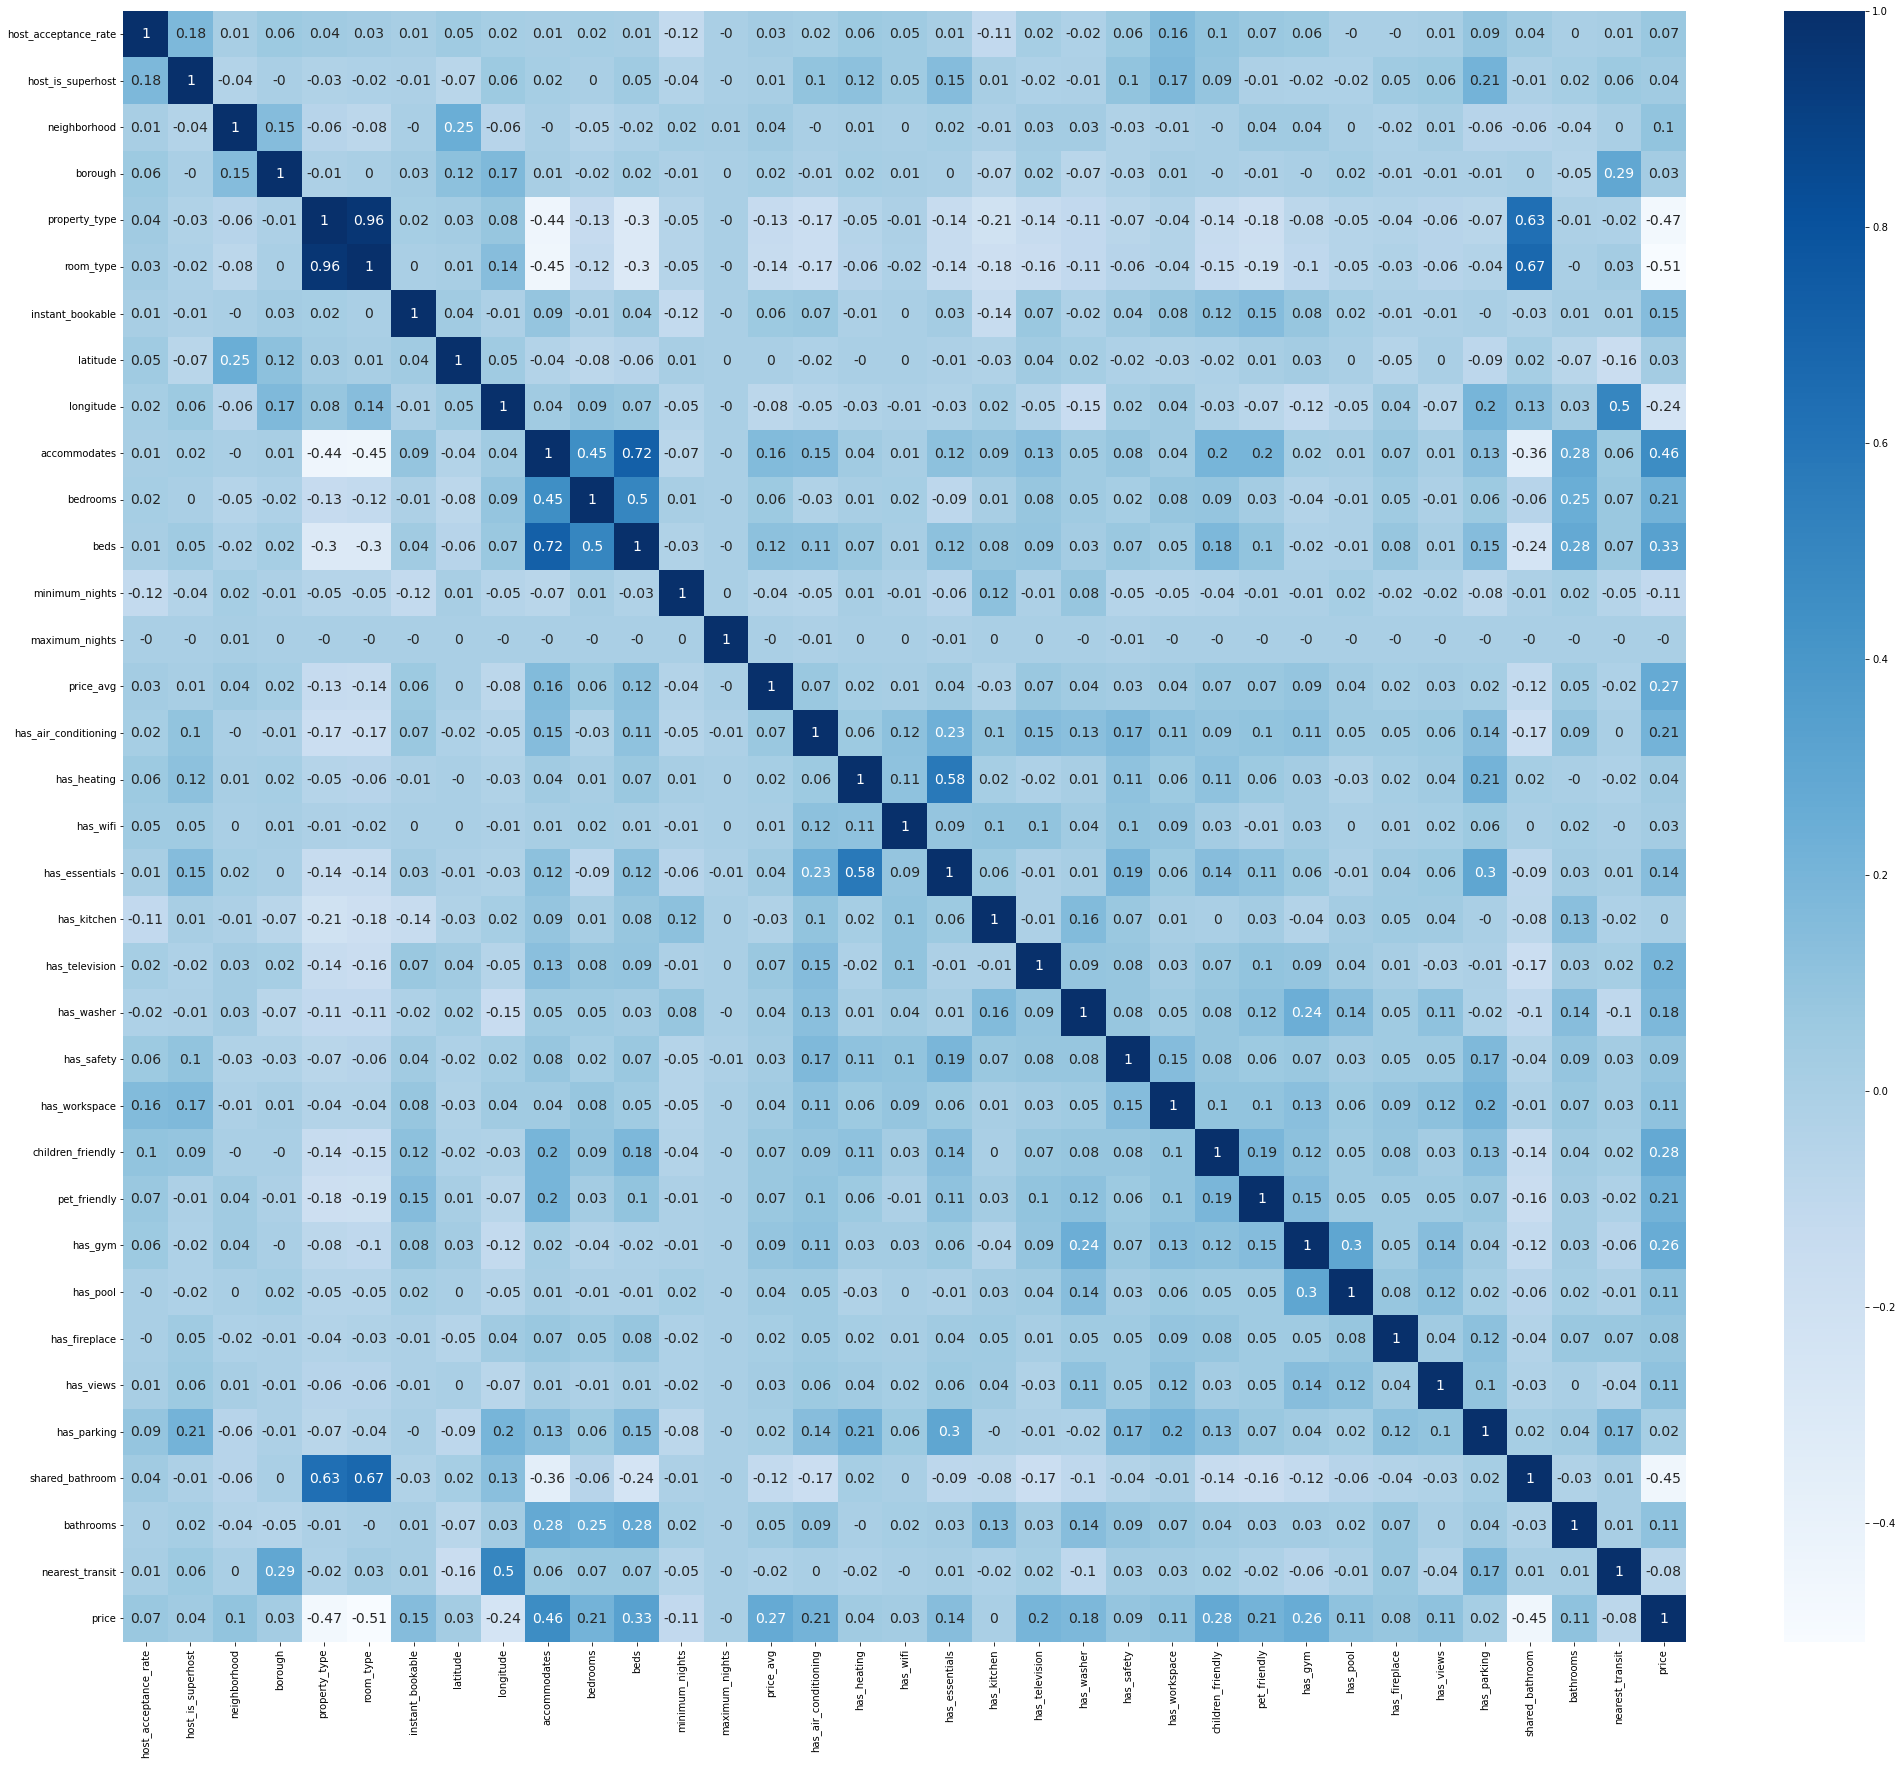

In [148]:
correlation_matrix = df_prepared.corr().round(2)
plt.figure(figsize=(35, 30))
sns.heatmap(correlation_matrix, cmap='Blues', annot=True, annot_kws={'fontsize': 14})
plt.show()

In [149]:
correlated_features=[]
for col in correlation_matrix.columns:
    correlation = correlation_matrix.loc[col, 'price']
    if abs(correlation) >= 0.05:
        correlated_features.append(col)

In [150]:
correlated_features

['host_acceptance_rate',
 'neighborhood',
 'property_type',
 'room_type',
 'instant_bookable',
 'longitude',
 'accommodates',
 'bedrooms',
 'beds',
 'minimum_nights',
 'price_avg',
 'has_air_conditioning',
 'has_essentials',
 'has_television',
 'has_washer',
 'has_safety',
 'has_workspace',
 'children_friendly',
 'pet_friendly',
 'has_gym',
 'has_pool',
 'has_fireplace',
 'has_views',
 'shared_bathroom',
 'bathrooms',
 'nearest_transit',
 'price']

In [151]:
X = df_prepared[['host_acceptance_rate',
 'neighborhood',
 'property_type',
 'room_type',
 'instant_bookable',
 'longitude',
 'accommodates',
 'bedrooms',
 'beds',
 'minimum_nights',
 'has_air_conditioning',
 'has_essentials',
 'has_television',
 'has_washer',
 'has_safety',
 'has_workspace',
 'children_friendly',
 'pet_friendly',
 'has_gym',
 'has_pool',
 'has_fireplace',
 'has_views',
 'shared_bathroom',
 'bathrooms',
 'nearest_transit']]

y = df_prepared['price']

# Add a constant term to the features matrix
X = sm.add_constant(X)

# Fit the multivariate linear regression model
price_model = sm.OLS(y, X).fit()

In [152]:
print(price_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     2044.
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:55:30   Log-Likelihood:            -3.2322e+05
No. Observations:               56866   AIC:                         6.465e+05
Df Residuals:                   56840   BIC:                         6.467e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.171e+04 

In [153]:
df_prepared['log_price'] = np.log(df_prepared['price'])

In [154]:
X = df_prepared[['host_acceptance_rate',
 'neighborhood',
 'property_type',
 'room_type',
 'instant_bookable',
 'longitude',
 'accommodates',
 'bedrooms',
 'beds',
 'minimum_nights',
 'has_air_conditioning',
 'has_essentials',
 'has_television',
 'has_washer',
 'has_safety',
 'has_workspace',
 'children_friendly',
 'pet_friendly',
 'has_gym',
 'has_pool',
 'has_fireplace',
 'has_views',
 'shared_bathroom',
 'bathrooms',
 'nearest_transit']]

y = df_prepared['log_price']

# Add a constant term to the features matrix
X = sm.add_constant(X)

# Fit the multivariate linear regression model
log_price_model = sm.OLS(y, X).fit()

In [155]:
print(log_price_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     2732.
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:56:21   Log-Likelihood:                -34086.
No. Observations:               56866   AIC:                         6.822e+04
Df Residuals:                   56840   BIC:                         6.846e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -144.6256 

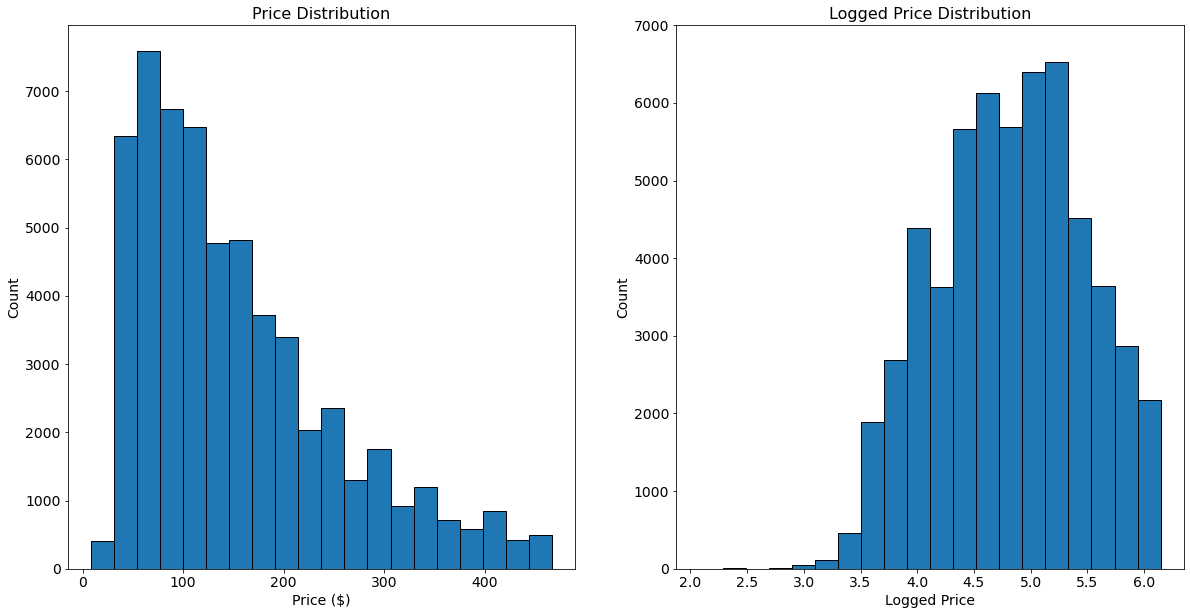

In [196]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].hist(df_prepared['price'], bins=20, edgecolor='black')
ax[0].set_title('Price Distribution', fontsize=16)
ax[0].set_xlabel('Price ($)', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)


ax[1].hist(df_prepared['log_price'], bins=20, edgecolor='black')
ax[1].set_title('Logged Price Distribution', fontsize=16)
ax[1].set_xlabel('Logged Price', fontsize=14)
ax[1].set_ylabel('Count', fontsize=14)
ax[1].set_ylim(0,7000)
ax[1].tick_params(axis='both', which='major', labelsize=14)


plt.show()

In [156]:
features = ['host_acceptance_rate',
 'neighborhood',
 'property_type',
 'room_type',
 'instant_bookable',
 'longitude',
 'accommodates',
 'bedrooms',
 'beds',
 'minimum_nights',
 'has_air_conditioning',
 'has_essentials',
 'has_television',
 'has_washer',
 'has_workspace',
 'children_friendly',
 'pet_friendly',
 'has_gym',
 'has_pool',
 'has_fireplace',
 'has_views',
 'shared_bathroom',
 'bathrooms',
 'nearest_transit']

X = df_prepared[features]
y = df_prepared.log_price

In [157]:
X.describe()

,host_acceptance_rate,neighborhood,property_type,room_type,instant_bookable,longitude,accommodates,bedrooms,beds,minimum_nights,...,has_workspace,children_friendly,pet_friendly,has_gym,has_pool,has_fireplace,has_views,shared_bathroom,bathrooms,nearest_transit
count,56866.000000,56866.000000,56866.000000,56866.000000,56866.000000,56866.000000,56866.000000,56866.000000,56866.000000,56866.000000,...,56866.000000,56866.000000,56866.000000,56866.000000,56866.000000,56866.000000,56866.000000,56866.000000,56866.000000,56866.000000
mean,37.410685,107.604104,31.290578,0.480762,0.212253,-73.942555,2.703091,1.252031,1.516425,24.556044,...,0.510692,0.094239,0.208455,0.155242,0.029350,0.060968,0.053353,0.280326,1.135898,0.337580
std,39.693795,67.866183,16.960880,0.527240,0.408907,0.057544,1.763015,0.754690,1.009766,22.278026,...,0.499890,0.292164,0.406207,0.362139,0.168786,0.239274,0.224739,0.449162,0.445486,0.506766
min,0.000000,0.000000,0.000000,0.000000,0.000000,-74.251907,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002350
25%,2.000000,53.000000,17.000000,0.000000,0.000000,-73.981530,2.000000,1.000000,1.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.130657
50%,2.000000,96.000000,17.000000,0.000000,0.000000,-73.951660,2.000000,1.000000,1.000000,30.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.204925
75%,81.000000,169.000000,49.000000,1.000000,0.000000,-73.922792,4.000000,1.000000,2.000000,30.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.323310
max,98.000000,223.000000,77.000000,2.000000,1.000000,-73.710870,16.000000,8.000000,22.000000,999.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.500000,4.984294


In [ ]:
X.shape

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
# Instantiate the Linear Regression model
reg_model = LinearRegression()

# Fit the model
reg_model.fit(X_train, y_train)

# Predict the model
y_pred_train_reg = reg_model.predict(X_train)
y_pred_test_reg = reg_model.predict(X_test)

# Evaluation Metrics for Linear Regression 
r2_train_reg = r2_score(y_train, y_pred_train_reg).round(4)
mse_train_reg = mse(y_train, y_pred_train_reg).round(4)
rmse_train_reg = (mse_train_reg**0.5).round(4)

r2_test_reg = r2_score(y_test, y_pred_test_reg).round(4)
mse_test_reg = mse(y_test, y_pred_test_reg).round(4)
rmse_test_reg = (mse_test_reg**0.5).round(4)

In [160]:
reg_metrics = {'R2':[r2_train_reg, r2_test_reg],
               'MSE':[mse_train_reg, rmse_test_reg],
               'RMSE':[rmse_train_reg, rmse_test_reg]}

reg_metrics_df = pd.DataFrame(reg_metrics)
reg_metrics_df = reg_metrics_df.rename(index={0:'Linear Regression Train Metrics',
                                              1:'Linear Regression Test Metrics'})

print('Linear Regression Metrics:\n')
print(reg_metrics_df)

Linear Regression Metrics:

                                     R2     MSE    RMSE
Linear Regression Train Metrics  0.5456  0.1950  0.4416
Linear Regression Test Metrics   0.5463  0.4371  0.4371


In [161]:
# Instantiate the Decision Tree Regressor model
decision_tree = DecisionTreeRegressor()  
  
# Fit the model with train data
decision_tree.fit(X_train, y_train)

# Predict the model with train and test data
y_pred_train_og_dt = decision_tree.predict(X_train)
y_pred_test_og_dt = decision_tree.predict(X_test)

# Evaluation Metrics for Decision Tree Regressor model
r2_train_og_dt = r2_score(y_train, y_pred_train_og_dt).round(4)
mse_train_og_dt = mse(y_train, y_pred_train_og_dt).round(4)
rmse_train_og_dt = (mse_train_og_dt**0.5).round(4)

r2_test_og_dt = r2_score(y_test, y_pred_test_og_dt).round(4)
mse_test_og_dt = mse(y_test, y_pred_test_og_dt).round(4)
rmse_test_og_dt = (mse_test_og_dt**0.5).round(4)

In [162]:
og_dt_metrics = {'R2':[r2_train_og_dt, r2_test_og_dt],
                 'MSE':[mse_train_og_dt, mse_test_og_dt],
                 'RMSE':[rmse_train_og_dt, rmse_test_og_dt]}

og_dt_metrics_df = pd.DataFrame(og_dt_metrics)
og_dt_metrics_df = og_dt_metrics_df.rename(index={0:'Decision Tree Train Metrics',
                                                  1:'Decision Tree Test Metrics'})

print('Decision Tree Regressor Metrics:\n')
print(og_dt_metrics_df)

Decision Tree Regressor Metrics:

                                 R2     MSE    RMSE
Decision Tree Train Metrics  0.9996  0.0002  0.0141
Decision Tree Test Metrics   0.4410  0.2355  0.4853


In [163]:
# Instantiate the Random Forest Regressor model
random_forest = RandomForestRegressor()

# Fit the model with train data
random_forest.fit(X_train, y_train)

# Predict the model with train and test data
y_pred_train_og_rf = random_forest.predict(X_train)
y_pred_test_og_rf = random_forest.predict(X_test)

# Evaluation Metrics for Random Forest Regressor model
r2_train_og_rf = r2_score(y_train, y_pred_train_og_rf).round(4)
mse_train_og_rf = mse(y_train, y_pred_train_og_rf).round(4)
rmse_train_og_rf = (mse_train_og_rf**0.5).round(4)

r2_test_og_rf = r2_score(y_test, y_pred_test_og_rf).round(4)
mse_test_og_rf = mse(y_test, y_pred_test_og_rf).round(4)
rmse_test_og_rf = (mse_test_og_rf**0.5).round(4)

In [164]:
og_rf_metrics = {'R2':[r2_train_og_rf, r2_test_og_rf],
                 'MSE':[mse_train_og_rf, mse_test_og_rf],
                 'RMSE':[rmse_train_og_rf, rmse_test_og_rf]}

og_rf_metrics_df = pd.DataFrame(og_rf_metrics)
og_rf_metrics_df = og_rf_metrics_df.rename(index={0:'Random Forest Train Metrics',
                                                  1:'Random Forest Test Metrics'})

print('Random Forest Regressor Metrics:\n')
print(og_rf_metrics_df)

Random Forest Regressor Metrics:

                                 R2     MSE    RMSE
Random Forest Train Metrics  0.9599  0.0172  0.1311
Random Forest Test Metrics   0.7142  0.1204  0.3470


In [165]:
# Instantiate the XGBoost Regressor model
xgboost = XGBRegressor()

# Fit the model with train data
xgboost.fit(X_train, y_train) 

# Predict the model with train and test data
y_pred_train_og_xgb = xgboost.predict(X_train) 
y_pred_test_og_xgb = xgboost.predict(X_test)

# Evaluation Metrics for XGBoost Regressor model
r2_train_og_xgb = r2_score(y_train, y_pred_train_og_xgb).round(4)
mse_train_og_xgb = mse(y_train, y_pred_train_og_xgb).round(4)
rmse_train_og_xgb = (mse_train_og_xgb**0.5).round(4)

r2_test_og_xgb = r2_score(y_test, y_pred_test_og_xgb).round(4)
mse_test_og_xgb = mse(y_test, y_pred_test_og_xgb).round(4)
rmse_test_og_xgb = (mse_test_og_xgb**0.5).round(4)

In [166]:
og_xgb_metrics = {'R2':[r2_train_og_xgb, r2_test_og_xgb],
                  'MSE':[mse_train_og_xgb, mse_test_og_xgb],
                  'RMSE':[rmse_train_og_xgb, rmse_test_og_xgb]}
                 
og_xgb_metrics_df = pd.DataFrame(og_xgb_metrics)
og_xgb_metrics_df = og_xgb_metrics_df.rename(index={0:'XGBoost Train Metrics',
                                                    1:'XGBoost Test Metrics'})

print('XGBoost Regressor Metrics:\n')
print(og_xgb_metrics_df)

XGBoost Regressor Metrics:

                           R2     MSE    RMSE
XGBoost Train Metrics  0.7769  0.0957  0.3094
XGBoost Test Metrics   0.7091  0.1226  0.3501


## Hyperparameter Tuning 
**Hyperparameter tuning will be applied on the Decision Tree Regressor, Random Forest Regressor, and XGBoost Regressor.**

A GridSearch was performed on the Decision Tree Regressor with parameters 'max_depth', 'max_leaf_nodes', and 'min_samples_leaf'. The best parameters of the Decision Tree Regressor were implemented in the Decision Tree Regressor and Random Forest Regressor.

A GridSearch was performed and applied on the XGBoost Regressor with parameters 'eta', 'subsample', and 'colsample_bytree'.

In [ ]:
# Define the hyperparameter grid for Decision Tree Regressor
decision_tree_param_grid = {'max_depth': [20, 25, 30], 
                            'max_leaf_nodes': [500, 750, 1000], 
                            'min_samples_leaf': [7, 10, 12]}

# Instantiate GridSearchCV for Decision Tree Regressor
decision_tree_grid_search = GridSearchCV(decision_tree, decision_tree_param_grid)

# Fit GridSearchCV to the data
decision_tree_grid_search.fit(X_train, y_train)

print("Best hyperparameters for Decision Tree Regressor: ", decision_tree_grid_search.best_params_)

In [167]:
# Instantiate Tuned Decision Tree Regressor
decision_tree_model = DecisionTreeRegressor(max_depth=20, max_leaf_nodes=500, min_samples_leaf=12)  
  
# Fit the model with train data
decision_tree_model.fit(X_train, y_train)

# Predict the model with train and test data
y_pred_train_dt = decision_tree_model.predict(X_train)
y_pred_test_dt = decision_tree_model.predict(X_test)

# Evaluation Metrics for Tuned Decision Tree Regressor model
r2_train_dt = r2_score(y_train, y_pred_train_dt).round(4)
mse_train_dt = mse(y_train, y_pred_train_dt).round(4)
rmse_train_dt = (mse_train_dt**0.5).round(4)

r2_test_dt = r2_score(y_test, y_pred_test_dt).round(4)
mse_test_dt = mse(y_test, y_pred_test_dt).round(4)
rmse_test_dt = (mse_test_dt**0.5).round(4)

In [168]:
dt_metrics = {'R2':[r2_train_dt, r2_test_dt],
              'MSE':[mse_train_dt, mse_test_dt],
              'RMSE':[rmse_train_dt, rmse_test_dt]}

dt_metrics_df = pd.DataFrame(dt_metrics)
dt_metrics_df = dt_metrics_df.rename(index={0:'Decision Tree (Tuned) Train Metrics',
                                            1:'Decision Tree (Tuned) Test Metrics'})

print('Tuned Decision Tree Regressor Metrics:\n')
print(dt_metrics_df)

Tuned Decision Tree Regressor Metrics:

                                         R2     MSE    RMSE
Decision Tree (Tuned) Train Metrics  0.6942  0.1312  0.3622
Decision Tree (Tuned) Test Metrics   0.6519  0.1466  0.3829


In [169]:
# Instantiate the Tuned Random Forest Regressor model
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=20, max_leaf_nodes=500, min_samples_leaf=12, random_state=42)

# Fit the model with train data
random_forest_model.fit(X_train, y_train)

# Predict the model with train and test data
y_pred_train_rf = random_forest_model.predict(X_train)
y_pred_test_rf = random_forest_model.predict(X_test)

# Evaluation Metrics for Tuned Random Forest Regressor model
r2_train_rf = r2_score(y_train, y_pred_train_rf).round(4)
mse_train_rf = mse(y_train, y_pred_train_rf).round(4)
rmse_train_rf = (mse_train_rf**0.5).round(4)

r2_test_rf = r2_score(y_test, y_pred_test_rf).round(4)
mse_test_rf = mse(y_test, y_pred_test_rf).round(4)
rmse_test_rf = (mse_test_rf**0.5).round(4)

In [170]:
rf_metrics = {'R2':[r2_train_rf, r2_test_rf],
              'MSE':[mse_train_rf, mse_test_rf],
              'RMSE':[rmse_train_rf, rmse_test_rf]}

rf_metrics_df = pd.DataFrame(rf_metrics)
rf_metrics_df = rf_metrics_df.rename(index={0:'Random Forest (Tuned) Train Metrics',
                                            1:'Random Forest (Tuned) Test Metrics'})

print('Tuned Random Forest Regressor Metrics:\n')
print(rf_metrics_df)

Tuned Random Forest Regressor Metrics:

                                         R2     MSE    RMSE
Random Forest (Tuned) Train Metrics  0.7246  0.1182  0.3438
Random Forest (Tuned) Test Metrics   0.6863  0.1322  0.3636


In [ ]:
# Define the hyperparameter grid for XGBoost Regressor
xgboost_param_grid = {'eta': [0.01, 0.05, 0.075],
                      'subsample': [0.625, 0.75, 0.875],
                      'colsample_bytree': [0.625, 0.75, 0.875]}

# Instantiate GridSearchCV for XGBoost Regressor
xgboost_grid_search = GridSearchCV(xgboost, xgboost_param_grid)

# Fit GridSearchCV to the data
xgboost_grid_search.fit(X_train, y_train)

print("Best hyperparameters for XGBoost Regressor: ", xgboost_grid_search.best_params_)

In [173]:
# Instantiate the XGBoost Regressor model
xgboost_model = XGBRegressor(n_estimators=100, max_depth=20, eta=0.0375, subsample=1, colsample_bytree=1)
  
# Fit the model with train data
xgboost_model.fit(X_train, y_train) 

# Predict the model with train and test data
y_pred_train_xgb = xgboost_model.predict(X_train) 
y_pred_test_xgb = xgboost_model.predict(X_test)

# Evaluation Metrics for XGBoost Regressor model
r2_train_xgb = r2_score(y_train, y_pred_train_xgb).round(4)
mse_train_xgb = mse(y_train, y_pred_train_xgb).round(4)
rmse_train_xgb = (mse_train_xgb**0.5).round(4)

r2_test_xgb = r2_score(y_test, y_pred_test_xgb).round(4)
mse_test_xgb = mse(y_test, y_pred_test_xgb).round(4)
rmse_test_xgb = (mse_test_xgb**0.5).round(4)

In [174]:
xgb_metrics = {'R2':[r2_train_xgb, r2_test_xgb],
               'MSE':[np.exp(mse_train_xgb).round(2), np.exp(mse_test_xgb).round(2)],
               'RMSE':[np.exp(rmse_train_xgb).round(2), np.exp(rmse_test_xgb).round(2)]}
                 
xgb_metrics_df = pd.DataFrame(xgb_metrics)
xgb_metrics_df = xgb_metrics_df.rename(index={0:'XGBoost (Tuned) Train Metrics',
                                              1:'XGBoost (Tuned) Test Metrics'})

print('Tuned XGBoost Regressor Metrics:\n')
print(xgb_metrics_df)

Tuned XGBoost Regressor Metrics:

                                   R2   MSE  RMSE
XGBoost (Tuned) Train Metrics  0.8984  1.04  1.23
XGBoost (Tuned) Test Metrics   0.6887  1.14  1.44


In [185]:
X_train['Price'] = np.exp(y_train)

In [183]:
X_train['Linear Regression Price'] = np.exp(y_pred_train_reg).round(2)
X_train['Decision Tree Price'] = np.exp(y_pred_train_dt).round(2)
X_train['Random Forest Price'] = np.exp(y_pred_train_rf).round(2)
X_train['XGBoost Price'] = np.exp(y_pred_train_xgb.astype(np.float64)).round(2)

In [186]:
price_comparison_train = X_train.iloc[:,-5:]
price_comparison_train.head(50)

,Linear Regression Price,Decision Tree Price,Random Forest Price,XGBoost Price,Price
20383,336.40,264.72,293.70,267.65,301.0
43530,134.37,172.90,164.73,133.24,121.0
26927,73.44,74.27,70.85,62.73,75.0
37910,132.36,122.78,111.53,96.26,110.0
34448,163.28,183.74,167.12,148.55,300.0
2233,185.11,132.95,158.22,131.31,125.0
42139,194.04,146.31,170.19,229.51,350.0
23261,107.95,128.19,150.37,150.64,168.0
17835,72.44,73.15,73.67,82.42,129.0
47722,172.86,234.45,242.93,213.42,260.0


In [179]:
X_test['Price'] = np.exp(y_test)

In [180]:
X_test['Linear Regression Price'] = np.exp(y_pred_test_reg).round(2)
X_test['Decision Tree Price'] = np.exp(y_pred_test_dt).round(2)
X_test['Random Forest Price'] = np.exp(y_pred_test_rf).round(2)
X_test['XGBoost Price'] = np.exp(y_pred_test_xgb.astype(np.float64)).round(2)

In [182]:
price_comparison = X_test.iloc[:,-5:]
price_comparison.head(50)

,Price,Linear Regression Price,Decision Tree Price,Random Forest Price,XGBoost Price
34762,65.0,82.91,104.11,101.66,74.73
53693,128.0,101.20,181.16,173.10,114.95
48094,149.0,133.96,90.24,100.06,97.21
24109,137.0,82.52,90.95,92.67,72.95
1866,107.0,61.68,50.83,52.90,45.07
19913,250.0,241.06,308.25,283.26,231.54
40276,84.0,76.85,97.61,94.27,79.27
52763,166.0,125.62,130.73,120.15,98.14
23176,250.0,137.73,197.69,160.88,144.37
5324,150.0,127.43,145.36,142.19,118.99


In [178]:
X_test = X_test.drop(columns=['Linear Regression Price', 'Decision Tree Price', 'Random Forest Price', 'XGBoost Price'])